<a href="https://colab.research.google.com/github/sj-minRva/Spam-Detection/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
data.shape

(5171, 4)

In [ ]:
# Check the count of each category
# This line calculates and prints the frequency of each unique value in 'label'
print(data['label'].value_counts())

# OPTIONAL: Check the percentage of each category
print(data['label'].value_counts(normalize=True) * 100)

label
ham     3672
spam    1499
Name: count, dtype: int64
label
ham     71.01141
spam    28.98859
Name: proportion, dtype: float64


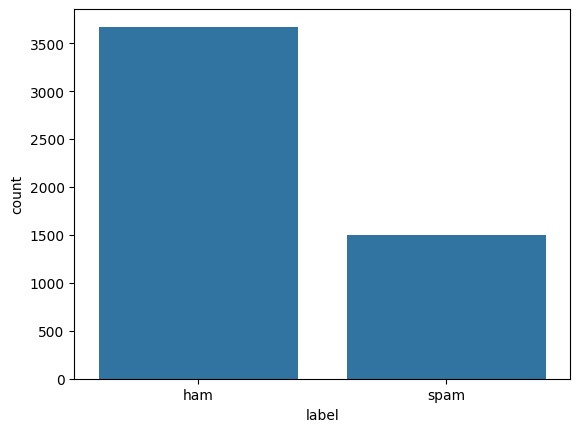

In [ ]:
sns.countplot(x='label', data=data)
plt.show()

Step 3: Balance the Dataset
We can clearly see that number of samples of Ham is much more than that of Spam which implies that the dataset we are using is imbalanced. To address the imbalance we’ll downsample the majority class (Ham) to match the minority class (Spam).

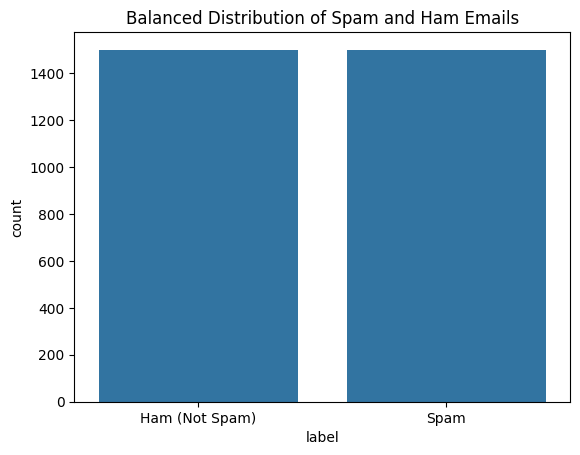

In [ ]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

"""
# Downsample Ham emails to match the number of Spam emails

1   ham_msg is a pandas DataFrame "ham" (legitimate) messages.
2   .sample() is a pandas method used to select a random sample of rows from a DataFrame.
3   n=len(spam_msg) specifies the number of samples to select.
4   random_state=42 sets a "seed" for the random number generator.
    This ensures that the same random sample is selected every time the code is run, making the results reproducible.
"""
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

# Combine balanced data
balanced_data = pd.concat([ham_msg_balanced, spam_msg]).reset_index(drop=True)

# Visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced Distribution of Spam and Ham Emails")
plt.xticks(ticks=[0, 1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

Step 4: Clean the Text
Textual data often requires preprocessing before feeding it into a machine learning model. Common steps include removing stopwords, punctuations, and performing stemming/lemmatization.

We’ll perform the following steps:
1. Stopwords Removal
2. Punctuations Removal
3. Stemming or Lemmatization

Although removing data means loss of information we need to do this to make the data perfect to feed into a machine learning model.

In [ ]:
#It removed the word "Subject" (which appears in every single row and is therefore useless info).
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,2982,ham,: feb 01 prod : sale to teco gas processing\r\...,0
2,2711,ham,": california energy crisis\r\ncalifornia  , s...",0
3,3116,ham,: re : nom / actual volume for april 23 rd\r\n...,0
4,1314,ham,: eastrans nomination changes effective 8 / 2 ...,0


In [ ]:
"""
Think of maketrans as creating a rulebook for the computer. It takes three arguments:
Argument 1 (Empty ''): Characters to replace. (We leave this empty).
Argument 2 (Empty ''): What to replace them with. (We leave this empty).
Argument 3 (punctuations_list): Characters to DELETE.
In plain English: This line tells Python: "I am not swapping any letters, but if you see anything from the punctuations_list, map it to None (delete it)."
"""
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,2982,ham,feb 01 prod sale to teco gas processing\r\ns...,0
2,2711,ham,california energy crisis\r\ncalifornia  s p...,0
3,3116,ham,re nom actual volume for april 23 rd\r\nwe ...,0
4,1314,ham,eastrans nomination changes effective 8 2 0...,0


In [ ]:


def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()
        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)

    return output


balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


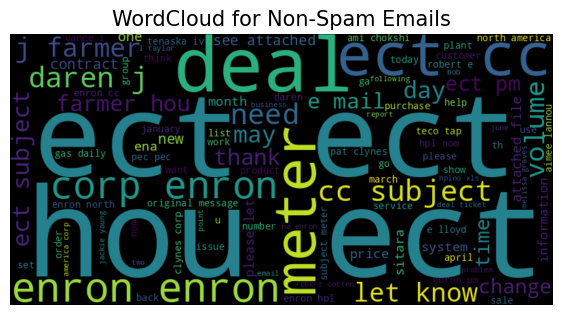

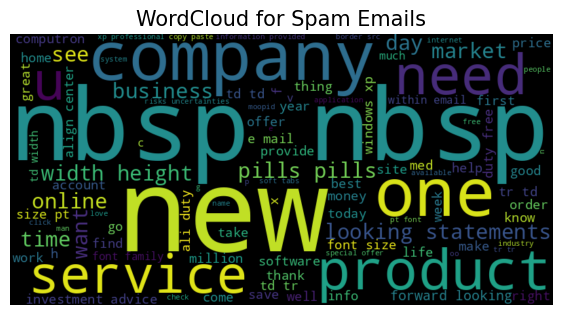

In [ ]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

Step 6: Tokenization and Padding
Machine learning models work with numbers, so we need to convert the text data into numerical vectors using Tokenization and Padding.

1. Tokenization: Converts each word into a unique integer.
2. Padding: Ensures that all text sequences have the same length, making them compatible with the model.

In [ ]:
# 80-20 split
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100  # Maximum sequence length
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

Step 7: Define the Model
We will build a deep learning model using a Sequential architecture. This model will include:

1. Embedding Layer: Learns vector representations of words.
2. LSTM Layer: Captures patterns in sequences.
3. Fully Connected Layer: Extracts relevant features.
4. Output Layer: Predicts whether an email is spam or not.



In [ ]:
model = tf.keras.models.Sequential([
    # Explicitly define input shape here
    tf.keras.layers.Input(shape=(max_len,)),

    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │     1,274,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,278,625 (4.88 MB)

 Trainable params: 1,278,625 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

Step 8: Train the Model

We train the model using EarlyStopping and ReduceLROnPlateau callbacks. These callbacks help stop the training early if the model’s performance doesn’t improve and reduce the learning rate to fine-tune the model.

In [ ]:
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr, es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5253 - loss: 0.6897 - val_accuracy: 0.7550 - val_loss: 0.5226 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8203 - loss: 0.4137 - val_accuracy: 0.9400 - val_loss: 0.2287 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9537 - loss: 0.1880 - val_accuracy: 0.9433 - val_loss: 0.2171 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9665 - loss: 0.1459 - val_accuracy: 0.9483 - val_loss: 0.2074 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9704 - loss: 0.1322 - val_accuracy: 0.9367 - val_loss: 0.2516 - learning_rate: 0.0010
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9309 - loss: 0.2519 - val_accuracy: 0.8333 - val_loss: 0.4027 - learning_rate: 0.0010
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8339 - loss: 0.3851 - val_acc

In [ ]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9518 - loss: 0.1956
Test Loss : 0.20741310715675354
Test Accuracy : 0.9483333230018616


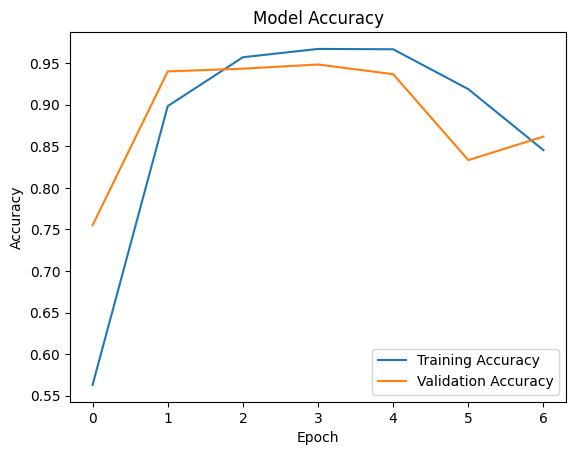

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()